In [4]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
import random
import sys
import io
import re

In [5]:
songs = pd.read_csv('data/drake-songs.csv')

In [6]:
text = ''

for index, row in songs['lyrics'].iteritems():
    cleaned = str(row).lower().replace(' ', '\n')
    text = text + " ".join(re.findall(r"[a-z']+", cleaned))
    
len(text)

367372

In [7]:
import re

tokens = re.findall(r"[a-z'\s]", text)

chars = sorted(list(set(tokens)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 28


In [8]:
chars

[' ',
 "'",
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [9]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

nb sequences: 122444


In [10]:
print('Vectorization...')

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [11]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

Build model...


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
_________________________________________________________________
activation_1 (Activation)    (None, 28)                0         
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________


In [13]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [14]:
def on_epoch_end(epoch, logs):
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [22]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    x, 
    y,
    batch_size=128,
    epochs=10,
    callbacks=[print_callback]
)

Epoch 1/10
122444/122444 [==============================] - 89s 726us/step - loss: 1.3089
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "l in love with the rollie i wake up and "
l in love with the rollie i wake up and i want that you have to be the way i want that i want that i want that i was and i still and i still and i say it was all this all the way i'm gone that i want that i want that i want that i want that you can take the way i want that i want that i want that you want that i want that i was all that i want that i want that i want that i want that i won't want that i want that i won't wanna save you 
----- diversity: 0.5
----- Generating with seed: "l in love with the rollie i wake up and "
l in love with the rollie i wake up and the hate get it i need a get it i get it i get it i'm trying to you don't wanna fuck it i'm the way it was boy it all the can't stane that you know you don't tried to make all the lost and you know the way no

/home/nikolaevra/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


ant the tate of the guill never be waitin' it i need me and they got a ming i want it they got a grame the wast i got it we're here there now you know it th
Epoch 5/10
122444/122444 [==============================] - 89s 724us/step - loss: 1.2385
----- Generating text after Epoch: 4
----- diversity: 0.2
----- Generating with seed: "nk all day if you don't start in the mor"
nk all day if you don't start in the more i got a lot of me i got a lot of my friends they know that i got a bandy the game and i got me i got a lot about me i got it i get it i get it i'm too good they got it they love i can't see it i'm the bound to spend all the bottom now when i'm a man like the bottom now when i got it i guess i get it i get it i'm the guest i get it i get it i'm too good to see the bone and the check i don't have 
----- diversity: 0.5
----- Generating with seed: "nk all day if you don't start in the mor"
nk all day if you don't start in the morer in the connect in the bound no love i want the c

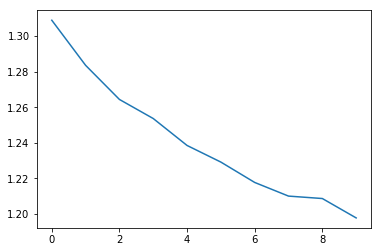

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])

In [24]:
def generate_output():
    generated = ''
    usr_input = input("Write the beginning of your poem, the Drake machine will complete it. Your input is: ")

    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 0.2)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [41]:
Tx = 40
generate_output()

Write the beginning of your poem, the Drake machine will complete it. Your input is: twenty percent pain thirty percent skill


Here is your poem: 

twenty percent pain thirty percent skill before the body i don't even won a real you know what i start to see it i'm trying to be all the city party the conders in the can but i got it i got no heave you don't wanna see it was and wine it i got no head to me and i would be start to me i got my word to me girl what i did i did it i won't dead that for the boy and the way the bout it i get it i get it i get it i get it i get it i get it i

In [20]:
import utils

In [ ]:
utils.save_model_weights(model)